In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/fer2013.csv


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [3]:
data = pd.read_csv('../input/fer2013/fer2013.csv')
print(data.shape)
data.head(10)

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


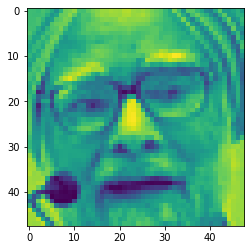

In [4]:
pyplot.imshow(np.array(data.pixels[1].split(' ')).reshape(48,48).astype('uint8'))

In [5]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [6]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [7]:
emotion_label = {
    0:'anger',
    1:'disgust',
    2:'fear',
    3:'happiness',
    4:'sadness',
    5:'surprise',
    6:'neutral'
}

# Expression Distribution

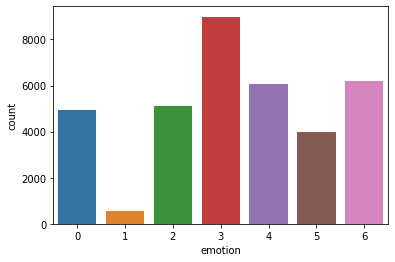

In [8]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
sns.countplot(data.emotion)
pyplot.show()

# Preparing the Data

In [9]:
X_train = []
y_train = []
X_test = []
y_test = []

for index, row in data.iterrows():
    temp = row.pixels.split(" ")
    if row.Usage == 'Training':
        X_train.append(np.array(temp))
        y_train.append(row.emotion)
    elif row.Usage == 'PublicTest':
        X_test.append(np.array(temp))
        y_test.append(row.emotion)

In [10]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

In [11]:
X_train = np.array(X_train, dtype='uint8')
y_train = np.array(y_train, dtype='uint8')
X_test = np.array(X_test, dtype='uint8')
y_test = np.array(y_test, dtype='uint8')

In [12]:
X_train[0]

array([ 70,  80,  82, ..., 106, 109,  82], dtype=uint8)

In [13]:
y_train[:10]

array([0, 0, 2, 4, 6, 2, 4, 3, 3, 2], dtype=uint8)

In [14]:
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [15]:
y_train[:10]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

# Reshaping the Data

In [16]:
X_train.shape

(28709, 2304)

In [17]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [18]:
X_train.shape

(28709, 48, 48, 1)

# Image Augmentation

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest'
)

In [20]:
testgen = ImageDataGenerator(rescale=1./255)
datagen.fit(X_train)
testgen.fit(X_test)

In [21]:
batch_size = 64

**Fitting Generator**

In [22]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

# Building the CNN Model

In [23]:
cnn = models.Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=(1, 1), input_shape=(48, 48, 1), padding="same"),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=(1, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=(1, 1), padding="same"),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=(1, 1)),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', strides=(1, 1), padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', strides=(1, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(7, activation='softmax')
])

In [24]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       7

# Compiling the Model

In [25]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001, decay=1e-6)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training the Model

In [26]:
num_epochs = 100  
history = cnn.fit(
    train_flow, 
    steps_per_epoch=len(X_train) / batch_size, 
    epochs=num_epochs,  
    verbose=1,  
    validation_data=test_flow,
    validation_steps=len(X_test) / batch_size
)

Epoch 1/100
448/448 [==============================] - 20s 39ms/step - loss: 1.8549 - accuracy: 0.3254 - val_loss: 2.4360 - val_accuracy: 0.2811
Epoch 2/100
448/448 [==============================] - 16s 35ms/step - loss: 1.4992 - accuracy: 0.4193 - val_loss: 1.3904 - val_accuracy: 0.4622
Epoch 3/100
448/448 [==============================] - 16s 37ms/step - loss: 1.3826 - accuracy: 0.4672 - val_loss: 1.3364 - val_accuracy: 0.4865
Epoch 4/100
448/448 [==============================] - 16s 35ms/step - loss: 1.3050 - accuracy: 0.4974 - val_loss: 1.3121 - val_accuracy: 0.5046
Epoch 5/100
448/448 [==============================] - 15s 34ms/step - loss: 1.2493 - accuracy: 0.5241 - val_loss: 1.1850 - val_accuracy: 0.5542
Epoch 6/100
448/448 [==============================] - 17s 37ms/step - loss: 1.1986 - accuracy: 0.5432 - val_loss: 1.1607 - val_accuracy: 0.5648
Epoch 7/100
448/448 [==============================] - 16s 35ms/step - loss: 1.1710 - accuracy: 0.5551 - val_loss: 1.1676 - val_ac

In [27]:
cnn_json = cnn.to_json()
with open("cnn.json", "w") as json_file:
    json_file.write(cnn_json)
cnn.save_weights("cnn.h5")
print("Saved model to disk")

Saved model to disk


In [29]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

print(f'Training Accuracy: {np.max(accuracy)}')
print(f'Training Loss: {np.min(loss)}')
print(f'Validation Accuracy: {np.max(val_accuracy)}')
print(f'Validation Loss: {np.min(val_loss)}')

Training Accuracy: 0.9569124579429626
Training Loss: 0.1314932256937027
Validation Accuracy: 0.6731680035591125
Validation Loss: 1.027877926826477


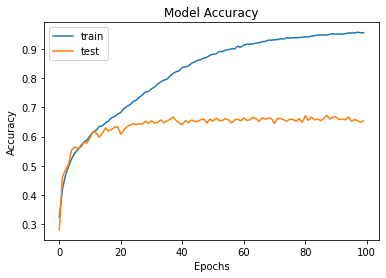

In [30]:
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('Model Accuracy')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.legend(['train', 'test'], loc='upper left')

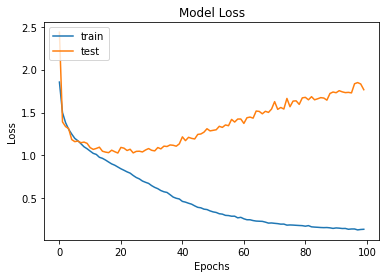

In [31]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model Loss')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend(['train', 'test'], loc='upper left')